## Valores missing, outlier y correlaciones

En este notebook se realiza el estudio y preprocesamiento de las variables numéricas y categoricas. Se realizarán los siguientes pasos:

1. Cambio de tipos de variables
2. Separación en train y test
3. Análisis de cada variable con gráficos descriptivos
4. Para variables numericas: correlaciones de pearnson, estudio de outliers y estudio de valores missing
5. Para variables categoricas: relleno de valores missing, estudio de correlaciones con vCramer


### Importo librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
import scipy.stats as ss
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

### Funciones

In [2]:
def plot_feature(df, col_name, isContinuous, target):
    """
    Visualize a variable with and without faceting on the loan status.
    - df dataframe
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    if isContinuous:
        sns.boxplot(x=col_name, y=target, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by '+target)
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [col_name, target, 'proportion']
        #sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        ax2.set_ylabel(target+' fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()
    

def dame_variables_categoricas(dataset=None):
    '''
    ----------------------------------------------------------------------------------------------------------
    Función dame_variables_categoricas:
    ----------------------------------------------------------------------------------------------------------
        -Descripción: Función que recibe un dataset y devuelve una lista con los nombres de las 
        variables categóricas
        -Inputs: 
            -- dataset: Pandas dataframe que contiene los datos
        -Return:
            -- lista_variables_categoricas: lista con los nombres de las variables categóricas del
            dataset de entrada con menos de 100 valores diferentes
            -- 1: la ejecución es incorrecta
    '''
    if dataset is None:
        print(u'\nFaltan argumentos por pasar a la función')
        return 1
    lista_variables_categoricas = []
    other = []
    for i in dataset.columns:
        if (dataset[i].dtype!=float) & (dataset[i].dtype!=int):
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                lista_variables_categoricas.append(i)
            else:
                other.append(i)

    return lista_variables_categoricas, other


def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0

def get_deviation_of_mean_perc(pd_loan, list_var_continuous, target, multiplier):
    """
    Devuelve el porcentaje de valores que exceden del intervalo de confianza
    :type series:
    :param multiplier:
    :return:
    """
    pd_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = pd_loan[i].mean()
        series_std = pd_loan[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_loan[i].size
        
        perc_goods = pd_loan[i][(pd_loan[i] >= left) & (pd_loan[i] <= right)].size/size_s
        perc_excess = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_loan[target][(pd_loan[i] < left) | (pd_loan[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0]]
                                         
            pd_concat_percent = pd_concat_percent
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final


def get_percent_null_values_target(pd_loan, list_var_continuous, target):

    pd_final = pd.DataFrame()
    for i in list_var_continuous:
        if pd_loan[i].isnull().sum()>0:
            pd_concat_percent = pd.DataFrame(pd_loan[target][pd_loan[i].isnull()]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.reset_index(drop=True)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_null_values'] = pd_loan[i].isnull().sum()
            pd_concat_percent['porcentaje_sum_null_values'] = pd_loan[i].isnull().sum()/pd_loan.shape[0]
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final



def cramers_v(confusion_matrix):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    
    confusion_matrix: tabla creada con pd.crosstab()
    
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

## Lectura de datos del preprocesado inicial

In [3]:
df_fraud = pd.read_csv('./data_preprocessing/df_fraud_initial_preprocessing2.csv')\
                      .drop('Unnamed: 0', axis=1)

df_fraud.shape

(1000000, 32)

In [4]:
df_fraud.head()

fraud_bool  income  name_email_similarity  prev_address_months_count  \
0         1.0     0.9               0.166828                       -1.0   
1         1.0     0.9               0.296286                       -1.0   
2         1.0     0.9               0.044985                       -1.0   
3         1.0     0.9               0.159511                       -1.0   
4         1.0     0.9               0.596414                       -1.0   

   current_address_months_count  customer_age  days_since_request  \
0                          88.0          50.0            0.020925   
1                         144.0          50.0            0.005418   
2                         132.0          40.0            3.108549   
3                          22.0          50.0            0.019079   
4                         218.0          50.0            0.004441   

   intended_balcon_amount payment_type  zip_count_4w   velocity_6h  \
0               -1.331345           AA         769.0  10650.765523   
1               -0.816224           AB         366.0    534.047319   
2               -0.755728           AC         870.0   4048.534263   
3               -1.205124           AB         810.0   3457.064063   
4               -0.773276           AB         890.0   5020.341679   

   velocity_24h  velocity_4w  bank_branch_count_8w  \
0   3134.319630  3863.647740                   1.0   
1   2670.918292  3124.298166                 718.0   
2   2893.621498  3159.590679                   1.0   
3   4054.908412  3022.261812                1921.0   
4   2728.237159  3087.670952                1990.0   

   date_of_birth_distinct_emails_4w employment_status  credit_risk_score  \
0                               6.0                CA              185.0   
1                               3.0                CA              259.0   
2                              14.0                CB              177.0   
3                               6.0                CA              110.0   
4                               2.0                CA              295.0   

   email_is_free housing_status  phone_home_valid  phone_mobile_valid  \
0            0.0             BA               1.0                 0.0   
1            1.0             BA               0.0                 0.0   
2            1.0             BA               0.0                 1.0   
3            1.0             BA               0.0                 1.0   
4            1.0             BA               1.0                 0.0   

   bank_months_count  has_other_cards  proposed_credit_limit  foreign_request  \
0               24.0              0.0                  500.0              0.0   
1               15.0              0.0                 1500.0              0.0   
2               -1.0              0.0                  200.0              0.0   
3               31.0              1.0                  200.0              0.0   
4               31.0              0.0                 1500.0              0.0   

     source  session_length_in_minutes  device_os  keep_alive_session  \
0  INTERNET                   3.888115    windows                 0.0   
1  INTERNET                  31.798819    windows                 0.0   
2  INTERNET                   4.728705      other                 0.0   
3  INTERNET                   2.047904      linux                 0.0   
4  INTERNET                   3.775225  macintosh                 1.0   

   device_distinct_emails_8w  device_fraud_count  month  
0                        1.0                 0.0    7.0  
1                        1.0                 0.0    7.0  
2                        1.0                 0.0    7.0  
3                        1.0                 0.0    7.0  
4                        1.0                 0.0    7.0

In [5]:
df_fraud.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

In [15]:
list_var_cat, other = dame_variables_categoricas(dataset=df_fraud)
df_fraud[list_var_cat] = df_fraud[list_var_cat].astype("category")
list_var_continuous = list(df_fraud.select_dtypes('float').columns)
df_fraud[list_var_continuous] = df_fraud[list_var_continuous].astype(float)
df_fraud['fraud_bool'] = df_fraud['fraud_bool'].astype("float")
df_fraud.dtypes

fraud_bool                           float64
income                               float64
name_email_similarity                float64
prev_address_months_count            float64
current_address_months_count         float64
customer_age                         float64
days_since_request                   float64
intended_balcon_amount               float64
payment_type                        category
zip_count_4w                         float64
velocity_6h                          float64
velocity_24h                         float64
velocity_4w                          float64
bank_branch_count_8w                 float64
date_of_birth_distinct_emails_4w     float64
employment_status                   category
credit_risk_score                    float64
email_is_free                        float64
housing_status                      category
phone_home_valid                     float64
phone_mobile_valid                   float64
bank_months_count                    float64
has_other_

## Separación en train y test estratificado

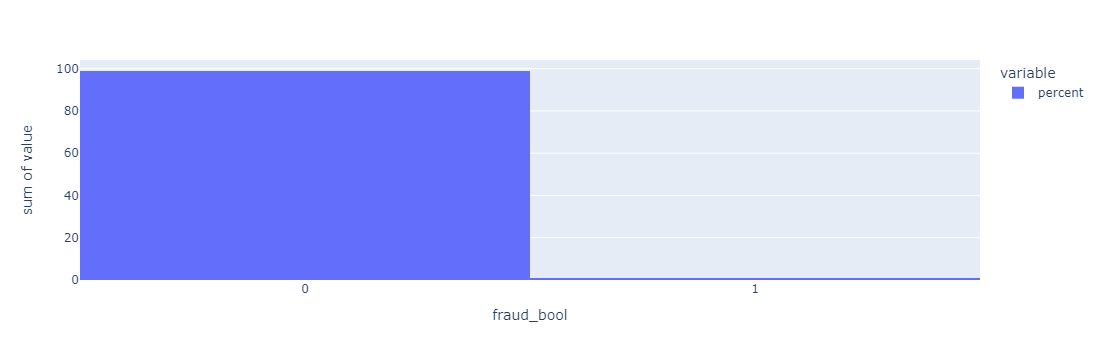

In [7]:
df_fraud_bool = df_fraud['fraud_bool'] \
    .value_counts(normalize=True) \
    .mul(100).rename('percent').reset_index()

df_fraud_bool_conteo = df_fraud['fraud_bool'].value_counts().reset_index()
df_fraud_bool_pc = pd.merge(df_fraud_bool, df_fraud_bool_conteo, on=['fraud_bool'], how='inner')
df_fraud_bool_pc
fig = px.histogram(df_fraud_bool_pc, x="fraud_bool", y=['percent'])
fig.update_xaxes(tickvals=[0, 1])
fig.show()

In [8]:
from sklearn.model_selection import train_test_split
X_df_fraud, X_df_fraud_test, y_df_fraud, y_df_fraud_test = train_test_split(df_fraud.drop('fraud_bool',axis=1), 
                                                                     df_fraud['fraud_bool'], 
                                                                     stratify=df_fraud['fraud_bool'], 
                                                                     test_size=0.2)
df_fraud_train = pd.concat([X_df_fraud, y_df_fraud],axis=1)
df_fraud_test = pd.concat([X_df_fraud_test, y_df_fraud_test],axis=1)

In [9]:
print('== Train\n', df_fraud_train['fraud_bool'].value_counts(normalize=True))
print('== Test\n', df_fraud_test['fraud_bool'].value_counts(normalize=True))

== Train
 fraud_bool
0.0    0.988971
1.0    0.011029
Name: proportion, dtype: float64
== Test
 fraud_bool
0.0    0.98897
1.0    0.01103
Name: proportion, dtype: float64


## Visualización descriptiva de los datos

In [10]:
# Parece que estás intentando verificar los valores nulos o valores específicos en tu conjunto de datos. (chatgpt)

# Lista de columnas para verificar valores nulos
check_missing_1 = ['prev_address_months_count', 'current_address_months_count', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']
check_missing_2 = ['intended_balcon_amount']

# Verificar valores nulos en todas las columnas
df_series_null_columns = (df_fraud_train == -1).sum().sort_values(ascending=False)
df_series_null_columns2 = (df_fraud_train[check_missing_2] < 0).sum()
concatenated_columns = pd.concat([df_series_null_columns, df_series_null_columns2], axis=0).sort_values(ascending=False)
df_null_columnas = pd.DataFrame(concatenated_columns, columns=['nulos_columnas'])
df_null_columnas['porcentaje_columnas'] = df_null_columnas['nulos_columnas'] / df_fraud_train.shape[0]

# Verificar valores nulos en filas específicas y asignar a la variable target
df_series_null_rows = (df_fraud_train == -1).sum(axis=1).sort_values(ascending=False)
df_series_null_rows2 = (df_fraud_train[check_missing_2] < 0).sum(axis=1)
concatenated_rows = pd.concat([df_series_null_rows, df_series_null_rows2], axis=0).sort_values(ascending=False)

df_null_filas = pd.DataFrame(concatenated_rows, columns=['nulos_filas'])
df_null_filas['target'] = df_fraud_train['fraud_bool'].copy()
df_null_filas['porcentaje_filas'] = df_null_filas['nulos_filas'] / df_fraud_train.shape[1]

# Muestra los resultados
print("Valores nulos en columnas:")
print(df_null_columnas)

print("\nValores nulos en filas:")
print(df_null_filas)

Valores nulos en columnas:
                                  nulos_columnas  porcentaje_columnas
intended_balcon_amount                    593945             0.742431
prev_address_months_count                 570170             0.712712
bank_months_count                         202938             0.253673
current_address_months_count                3397             0.004246
session_length_in_minutes                   1623             0.002029
credit_risk_score                            403             0.000504
device_distinct_emails_8w                    279             0.000349
velocity_6h                                    0             0.000000
bank_branch_count_8w                           0             0.000000
velocity_4w                                    0             0.000000
velocity_24h                                   0             0.000000
payment_type                                   0             0.000000
zip_count_4w                                   0             0.

In [11]:
columnas_numericas = df_fraud_train.select_dtypes(include=[np.number])
variables_numericas = columnas_numericas.columns.tolist()
print(variables_numericas)

['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month']


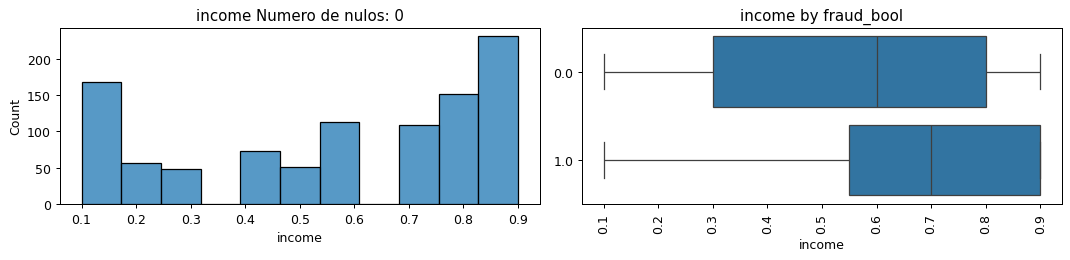

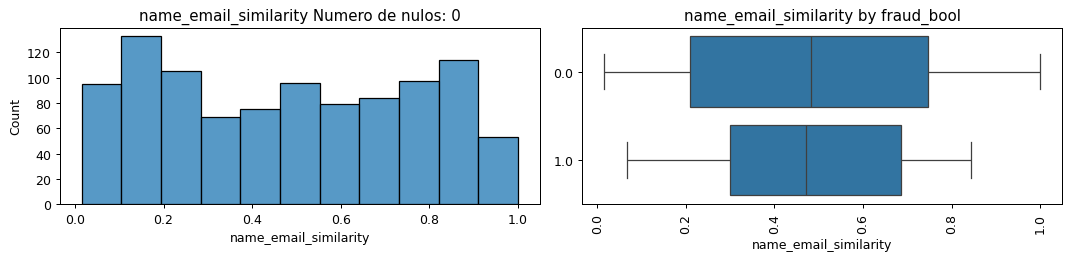

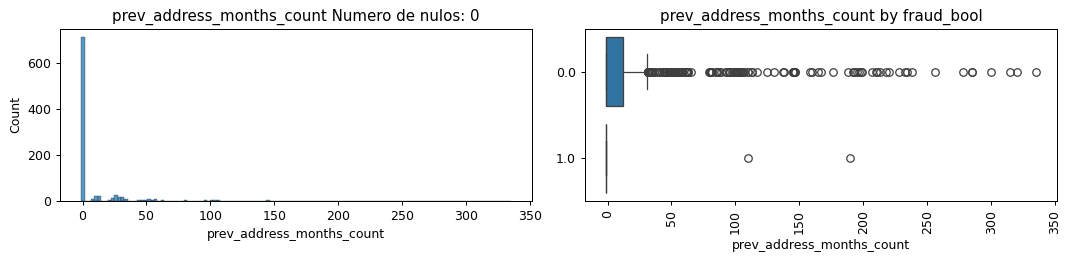

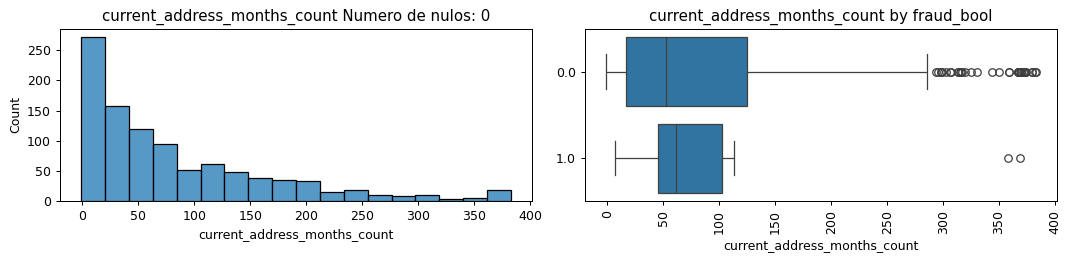

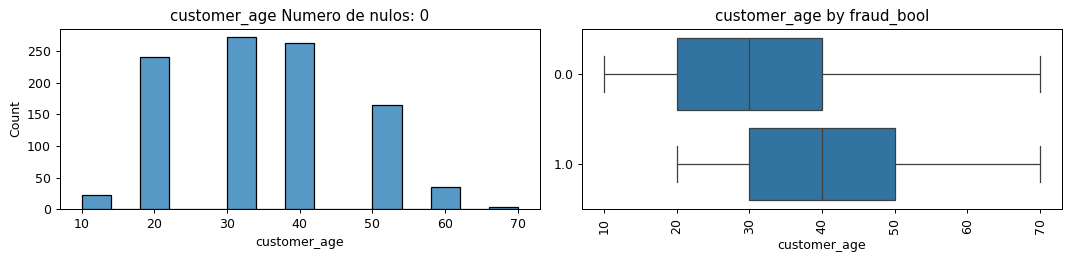

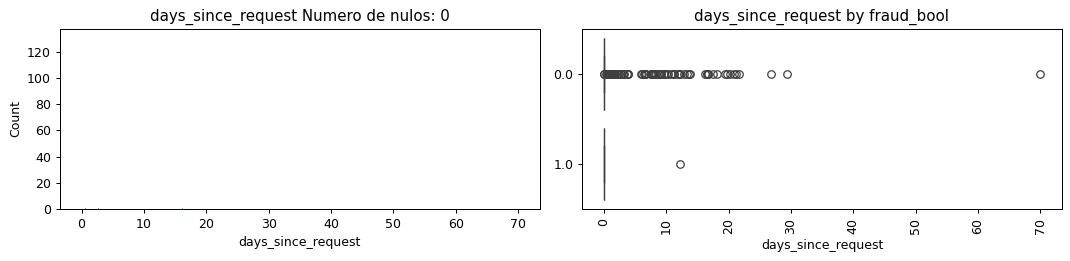

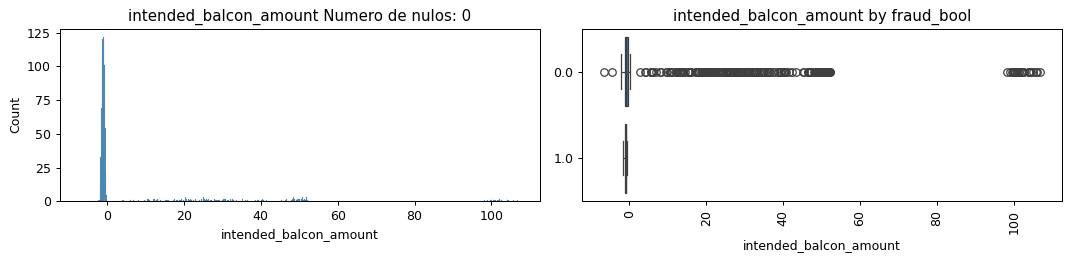

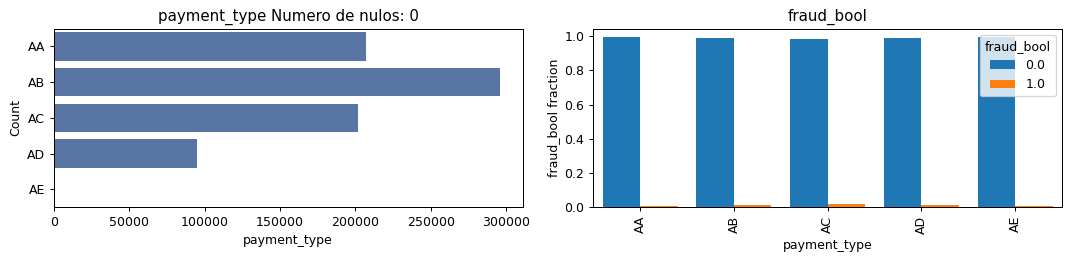

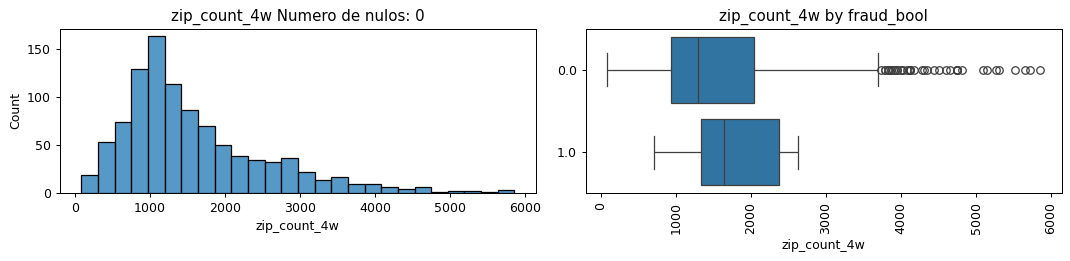

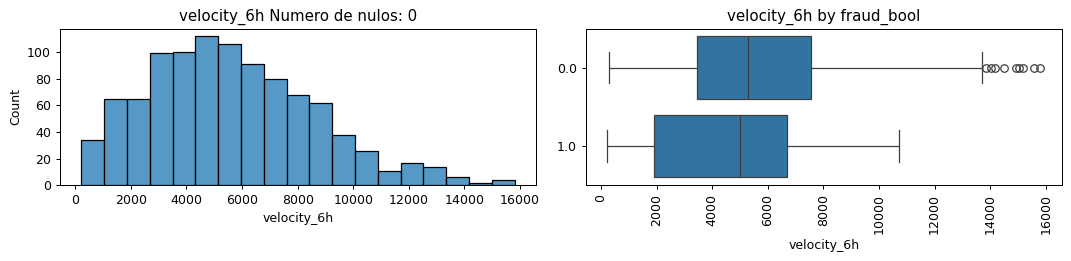

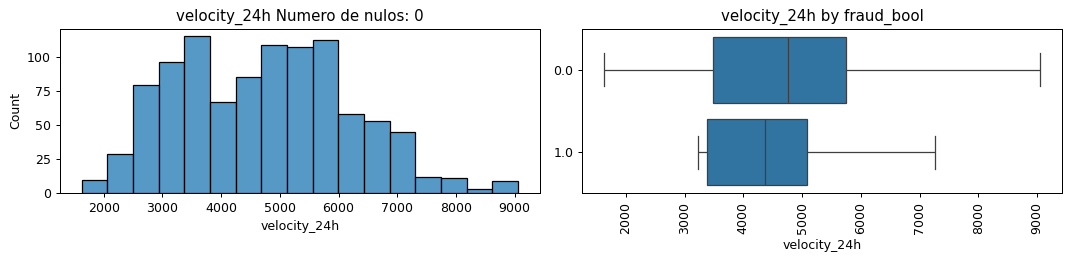

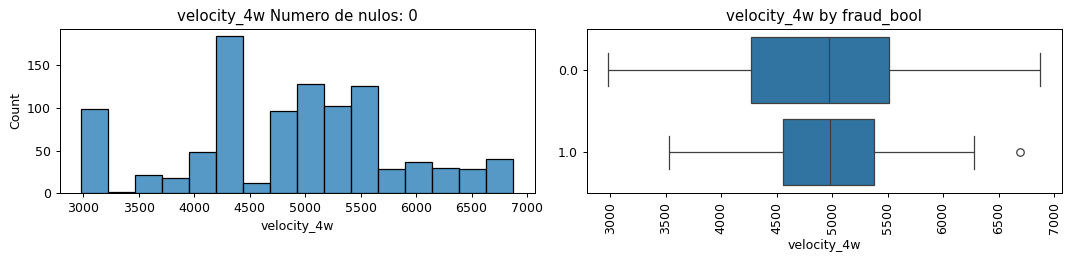

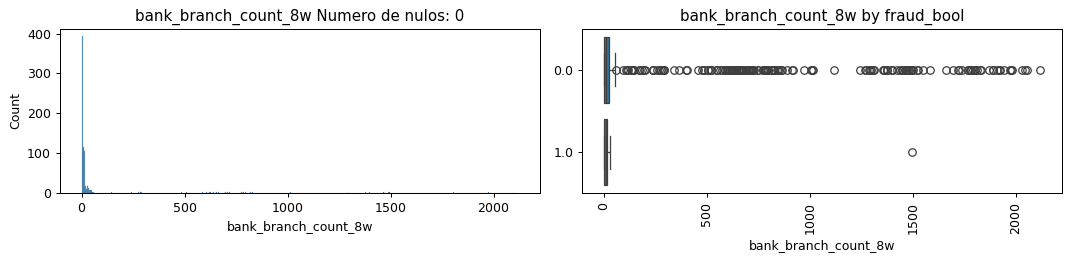

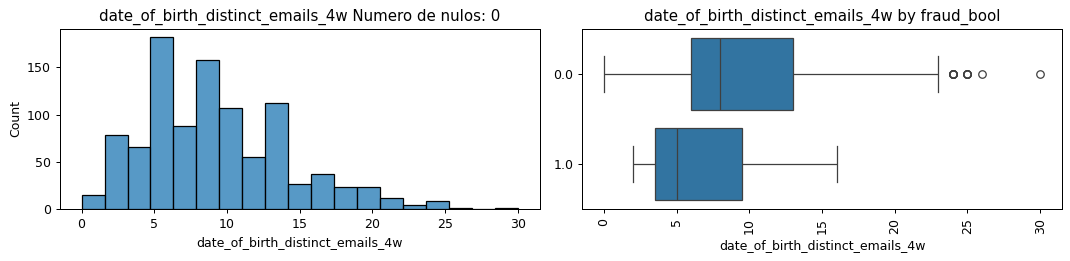

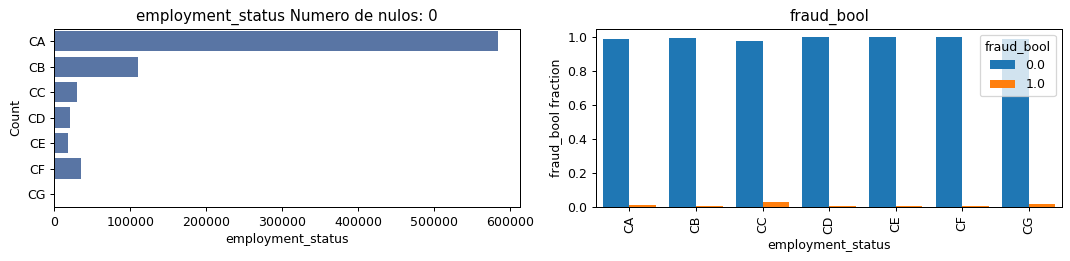

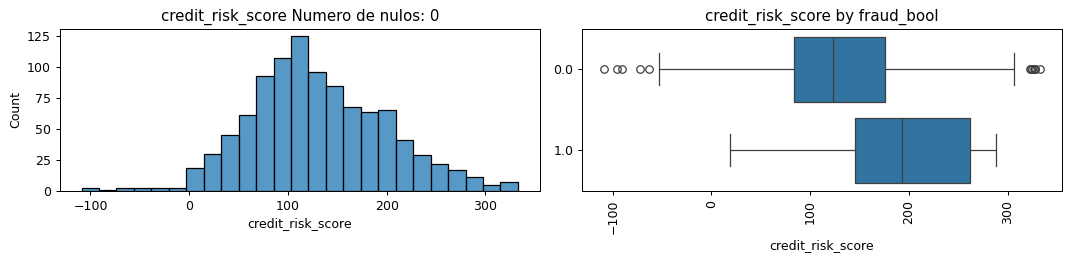

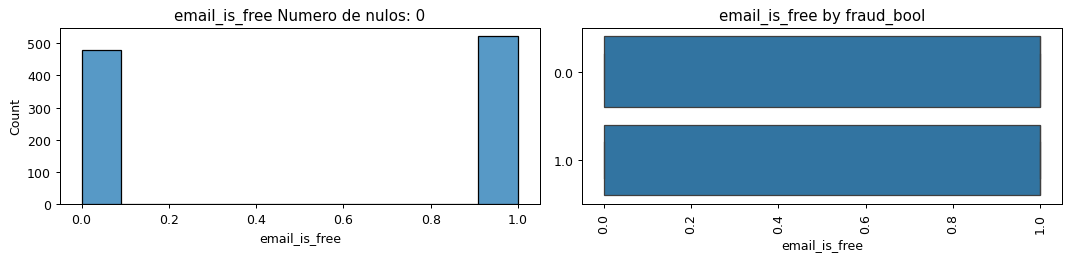

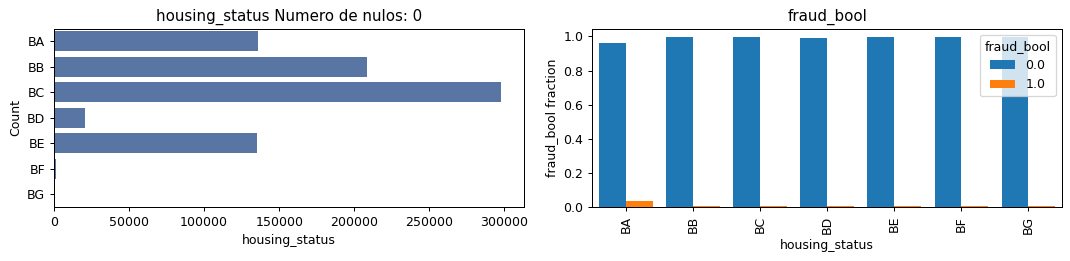

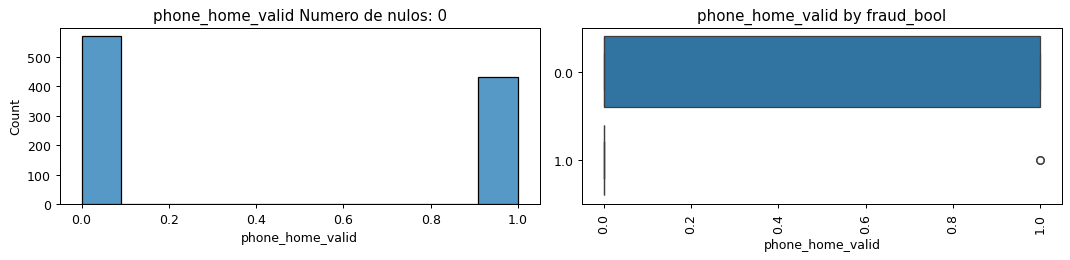

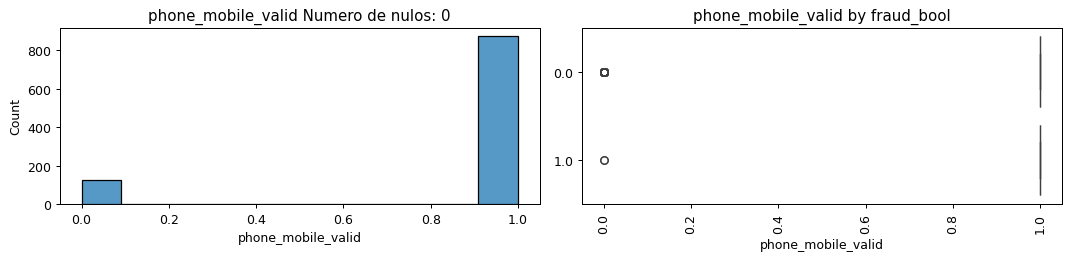

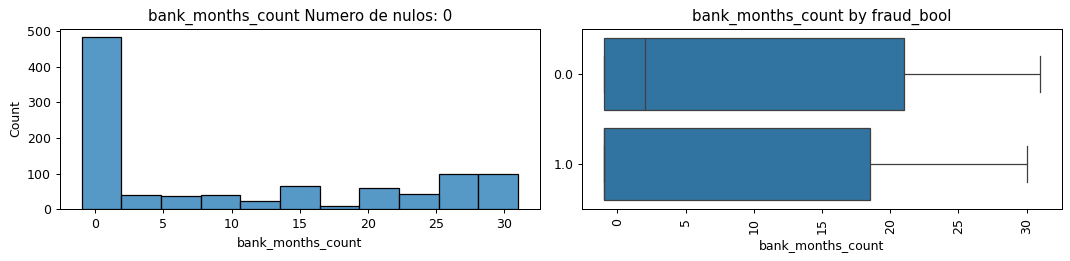

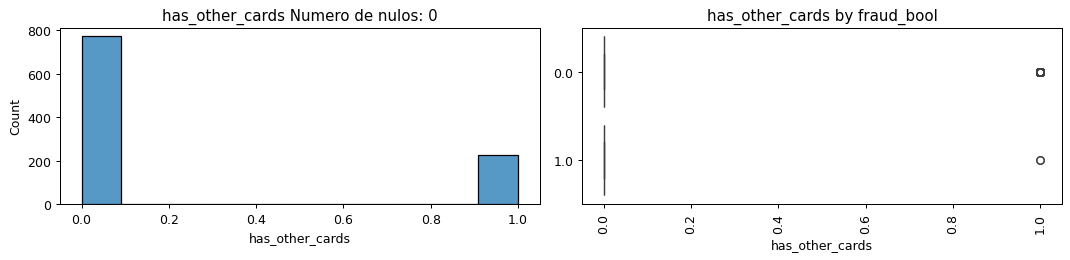

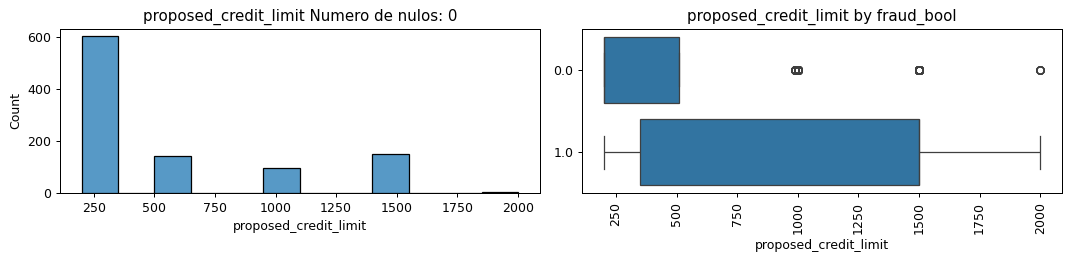

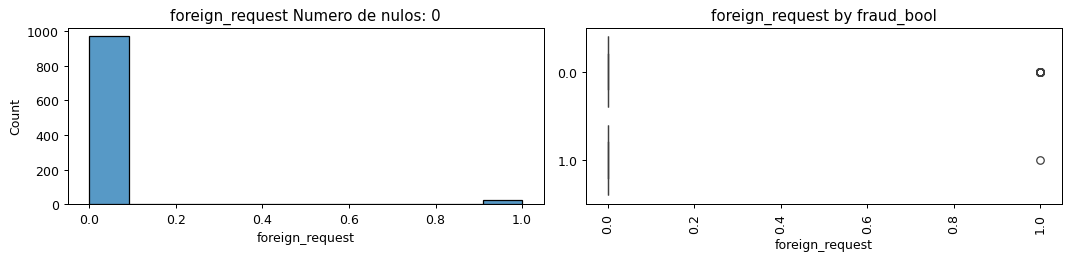

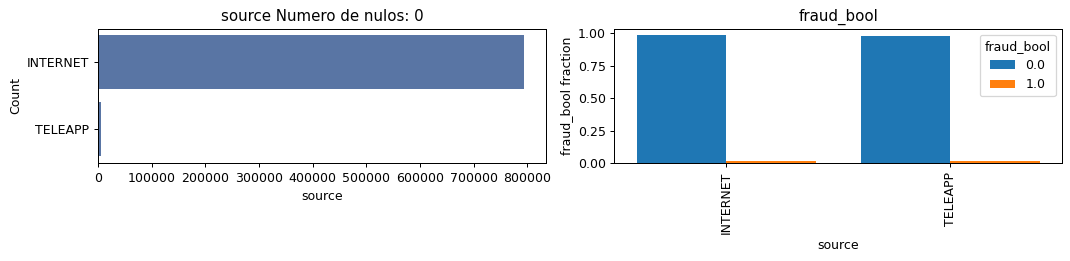

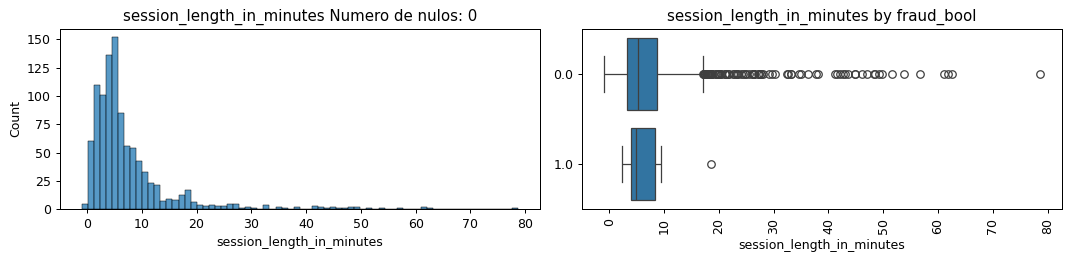

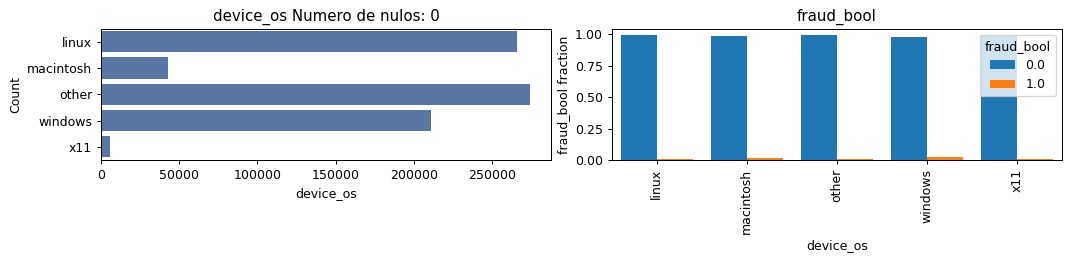

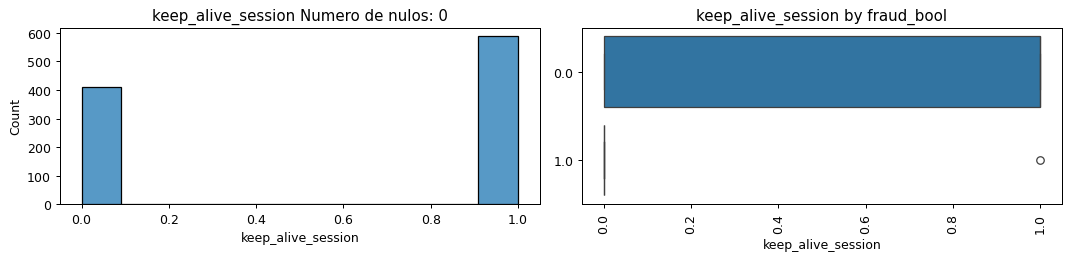

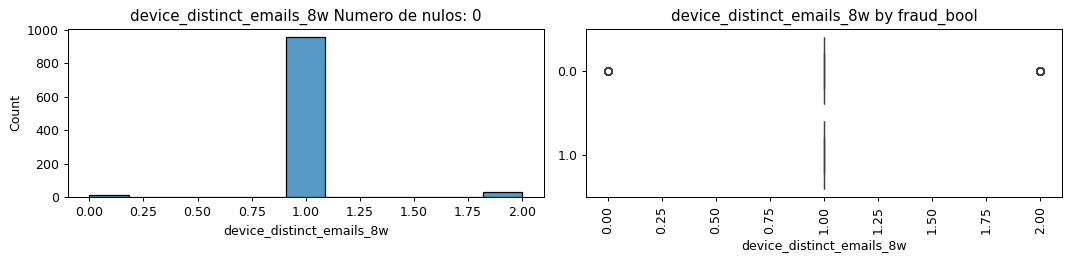

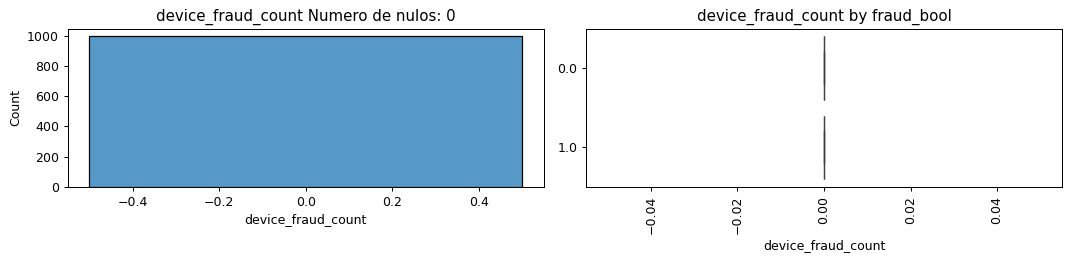

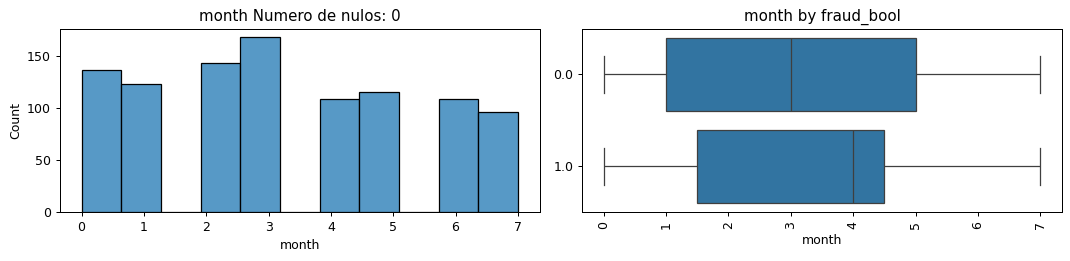

In [12]:
for i in list(df_fraud_train.columns):
    if (df_fraud_train[i].dtype==float) and (i!='fraud_bool'):
        plot_feature(df_fraud_train.head(1000), col_name=i, isContinuous=True, target='fraud_bool')
    elif i!='fraud_bool':
        plot_feature(df_fraud_train, col_name=i, isContinuous=False, target='fraud_bool')

## - Tratamiento de las variables continuas

In [13]:
list_var_continuous

['fraud_bool',
 'income',
 'name_email_similarity',
 'prev_address_months_count',
 'current_address_months_count',
 'customer_age',
 'days_since_request',
 'intended_balcon_amount',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'credit_risk_score',
 'email_is_free',
 'phone_home_valid',
 'phone_mobile_valid',
 'bank_months_count',
 'has_other_cards',
 'proposed_credit_limit',
 'foreign_request',
 'session_length_in_minutes',
 'keep_alive_session',
 'device_distinct_emails_8w',
 'device_fraud_count',
 'month']

## Tratamiento de outliers

Los valores outlier se pueden sustituir por la media, mediana, valores extremos (media+3std o media-3std). Tras el siguiente análisis, he decidido como primera iteración dejarlos sin sustituir, para preservar los datos y que no exista una distorsión de los mismos. Más tarde lo haré.

In [16]:
get_deviation_of_mean_perc(df_fraud_train, list_var_continuous, target='fraud_bool', multiplier=3)

ValueError: Length mismatch: Expected axis has 2 elements, new values have 1 elements

## Correlaciones

In [ ]:
get_corr_matrix(dataset = df_fraud_train[list_var_continuous], 
                metodo='pearson', size_figure=[8,6])

In [ ]:
corr = df_fraud_train[list_var_continuous].corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.3]

## Tratamiento de valores nulos

Dependiendo del contexto donde procedan las variables, se podrán imputar de una manera u otra. Por ejemplo, valores nulos dentro de la variable número de cuentas bancarias puede significar que la persona no tiene cuentas bancarias, por lo que el valor conveniente para rellenar el nulo es cero.

En caso de no tener tanto contexto de las variables, es posible optar por diferentes técnicas y contrastar los resultados del modelo:

Opción 0:
Algunos algoritmos aceptan en su input valores missing

Op*ción 1:
eliminar todas las filas que tengan valores nulos. En nuestro dataset no es lo más optimo debido a que hay bastantes filas que les ocurre esta sitOación

Opción 2:
Imputar los valores missing por:

media
mediana
maximo
minimo
valores extremos https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html
Decido rellenar todas las columnas continuas menos 'fraud_bool' por el valor -99. De esta manera, diferencio los outlier del resto de la muestra poninendo un valor muy separado del resto de la variable. Se puede explorar el resultado del modelo utilizando diferentes métodos

### Opción 2

In [ ]:
list_var_cat

In [ ]:
get_percent_null_values_target(df_fraud_train, list_var_continuous, target='fraud_bool')

In [ ]:
# data[list_var_continuous] = data[list_var_continuous].apply(lambda x: x.fillna(x.mean()))
# data[list_var_continuous] = data[list_var_continuous].apply(lambda x: x.fillna(x.median()))
# data[list_var_continuous] = data[list_var_continuous].apply(lambda x: x.fillna(x.std()))
# data[list_var_continuous] = data[list_var_continuous].apply(lambda x: x.fillna(x.max()))
# data[list_var_continuous] = data[list_var_continuous].apply(lambda x: x.fillna(x.min()))

list_vars = list(set(list_var_continuous)-set(['fraud_bool']))
df_fraud_train[list_vars] = df_fraud_train[list_vars].fillna(-99)
df_fraud_test[list_vars] = df_fraud_test[list_vars].fillna(-99)

In [ ]:
df_fraud_test['fraud_bool'].isnull().sum()

In [ ]:
get_percent_null_values_target(df_fraud_test, list_var_continuous, target='fraud_bool')

In [ ]:
list_vars

In [ ]:
df_fraud_test['fraud_bool'].isnull().sum()

In [ ]:
get_percent_null_values_target(df_fraud_test, list_var_continuous, target='fraud_bool')

### Opción 3

In [ ]:
X_train = df_fraud_train[list(set(list_var_continuous))]
X_test = df_fraud_test[list(set(list_var_continuous))]
imputer = KNNImputer(n_neighbors=2, weights="uniform")
model = imputer.fit(X_train)

df_fraud_input_train = pd.DataFrame(model.transform(X_train), 
                      columns=[i+'_input' for i in list(set(list_var_continuous))],index=df_fraud_train.index)
df_fraud_input_test = pd.DataFrame(model.transform(X_test), 
                      columns=[i+'_input' for i in list(set(list_var_continuous))],index=df_fraud_test.index)

df_fraud_input_train = pd.concat([df_fraud_train, df_fraud_input_train],axis=1).drop(list(set(list_var_continuous)),axis=1)
df_fraud_input_test = pd.concat([df_fraud_test, df_fraud_input_test],axis=1).drop(list(set(list_var_continuous)),axis=1)

In [ ]:
df_fraud_input_train.shape 

In [ ]:
df_fraud_input_train.columns

In [ ]:
get_percent_null_values_target(df_fraud_input_train, [i+'_input' for i in list_var_continuous], target='fraud_bool')

In [ ]:
list_var_continuous = list(df_fraud_input_train.select_dtypes('float').columns)
get_corr_matrix(dataset = df_fraud_input_train[list_var_continuous], 
                metodo='pearson', size_figure=[10,8])

In [ ]:
df_fraud_input_train.columns

## Tratamiento de las variales categoricas

In [ ]:
list_var_cat

In [ ]:
confusion_matrix = pd.crosstab(df_fraud_input_train["payment_type"], df_fraud_input_train["housing_status"])
print(confusion_matrix)
cramers_v(confusion_matrix.values)

## Tratamiento de valores nulos

In [ ]:
df_fraud_input_train[list_var_cat] = df_fraud_train[list_var_cat].astype("object").fillna("SIN VALOR").astype("category")
df_fraud_input_test[list_var_cat] = df_fraud_input_test[list_var_cat].astype("object").fillna("SIN VALOR").astype("category")

### Lo guardo en la tabla

In [ ]:
df_fraud_input_train.to_csv("./data_preprocessing/train_df_fraud_preprocessing_missing_outlier.csv")
df_fraud_input_test.to_csv("./data_preprocessing/test_df_fraud_preprocessing_missing_outlier.csv")

In [ ]:
print(df_fraud_input_train.shape, df_fraud_input_test.shape)

## EXPLICACIÓN

En primer lugar cargamos el datset del primer notebook, leemos los datos y nos asegurmaos que son o float o category.
Más tarde hacemos la separación del dataset entre train y test y representamos la suma de valores de fraud y legit, tanto antes de dividirlos como después por train y test, con la función objetivo 'fraud_bool'. 

Por otro lado, ejecutamos la visulaización descriptiva de los datos identificando los nulos y aplicamos el bucle para identificar los gráficos (en nuestro caso los gráficos no nos cargan, pero no es muy necesario el uso de estos).

El siguiente paso sería el tratamiento de outliers y de las variables categoricas, estas últimas son simplemente para identificarlas y saber que seguimos el camino correcto. 

El tratamiento de outliers no podemos estudiarlo ya que no conseguimos identificar el error. 

Continuando con la práctica ejecutamos la correlación de las variables, en la que podemos resaltar la fuerte correlación entre month y velocity_4w que nos indica que hay patrones estacionales o mensuales en la cantidad de solicitudes. Además podemos resaltar la segunda línea de correlación entre proposed_credit_limit y credit_risk_score que nos dice que las personas con una puntuación de riesgo crediticio más alta tienden a tener límites de crédito propuestos más altos.


Siguiendo con el tratamiento de valores nulos, hemos decidido aplicar la opción 3 ya que utiliza un modelo de regresión para rellenar los valores mmissing de alguna variable muy importante, por ejemplo: KNN, regresion lineal, xgboost. Uusndor KNNImputer para imputar los valores missing de la variable emp_length usando como regresoras todas las variables continua y obtenemos una matriz de correlación sin valores missing.


Además, tratamos las variables categoricas, en la que podemos visulizar una matriz de correlación en la que la tabla nos muestra que hay 30,728 observaciones en nuestro conjunto de datos donde los solicitantes tienen un estado de vivienda BA y han seleccionado el tipo de plan de pago de crédito AA. 


Por último, tratamos los valores nulos de nuestro train y test pasandolos a object o category respectivamente. 


Y lo guardamos en la tabla para el notebook3.s